<a href="https://colab.research.google.com/github/andrew-veriga/sunpower/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Получение данных из excel

In [23]:
import pandas as pd
import tensorflow as tf
import numpy as np
# df = pd.read_csv("https://github.com/andrew-veriga/sunpower/raw/master/SES_1_Cherny_Yar_-_gotovo.csv", parse_dates=["Дата"], index_col="Дата")
df = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_1_Cherny_Yar_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата")
df.head()


,№ п/п,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Общая облачность,"Текущая погода, сообщаемая с метеорологической станции",Прошедшая погода между сроками наблюдения 1,Прошедшая погода между сроками наблюдения 2,"Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака","Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm",Высота основания самых низких облаков (м),"Высококучевые, высокослоистые и слоисто-дождевые облака","Перистые, перисто-кучевые и перисто-слоистые облака",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,,,,,,,,,,,
2019-04-25 01:00:00.000,1,01:00:00,0.000000,9.1,766.4,766.9,68.0,247.5,2,Облаков нет.,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0
2019-04-25 04:00:00.000,2,04:00:00,0.147833,7.6,766.1,766.6,73.0,202.5,1,20–30%.,,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",Облаков нет.,"2500 или более, или облаков нет.","Высококучевых, высокослоистых или слоисто-дожд...",Перистые когтевидные или нитевидные или первые...,10.0
2019-04-25 06:59:59.995,3,07:00:00,5.024833,6.5,766.2,766.7,82.0,270.0,1,"10% или менее, но не 0",,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...","10% или менее, но не 0","2500 или более, или облаков нет.","Высококучевые просвечивающие, полосами, либо о...","Перистых, перисто-кучевых или перисто-слоистых...",10.0
2019-04-25 09:59:59.995,4,10:00:00,11.363389,18.8,766.7,767.2,34.0,90.0,1,"10% или менее, но не 0",,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...","10% или менее, но не 0","2500 или более, или облаков нет.",Высококучевые башенкообразные или хлопьевидные.,"Перистых, перисто-кучевых или перисто-слоистых...",10.0
2019-04-25 12:59:59.995,5,13:00:00,10.962667,23.0,766.3,766.9,22.0,90.0,2,20–30%.,,NaN,NaN,"Кучевые плоские или кучевые разорванные, или т...","10% или менее, но не 0",1000-1500,"Высококучевых, высокослоистых или слоисто-дожд...","Перистые нитевидные, иногда когтевидные, не ра...",10.0


доступные колонки

In [2]:
df.columns

Index(['№ п/п', 'Время', 'Мощность, МВт',
       'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
       'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
       'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
       'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
       'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
       'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
       'Общая облачность',
       'Текущая погода, сообщаемая с метеорологической станции ',
       'Прошедшая погода между сроками наблюдения 1',
       'Прошедшая погода между сроками наблюдения 2',
       'Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые обла

Int64Index([4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
            ...
            2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
           dtype='int64', name='Дата', length=2385)

Создание набора данных из числовых колонок

In [64]:
series = df[
            [
            'Время',
            'Мощность, МВт',
            'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
            'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
            'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
            'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
            'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
            'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
            # 'Общая облачность',
            # 'Текущая погода, сообщаемая с метеорологической станции ',
            # 'Прошедшая погода между сроками наблюдения 1',
            # 'Прошедшая погода между сроками наблюдения 2',
            # 'Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака',
            # 'Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm',
            # 'Высота основания самых низких облаков (м)',
            # 'Высококучевые, высокослоистые и слоисто-дождевые облака',
            # 'Перистые, перисто-кучевые и перисто-слоистые облака',
            'Горизонтальная дальность видимости (км)'
             ]].fillna(0)#.asfreq(None)
            
            
series.head()

,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,
2019-04-25 01:00:00.000,01:00:00,0.000000,9.1,766.4,766.9,68.0,247.5,2,10.0
2019-04-25 04:00:00.000,04:00:00,0.147833,7.6,766.1,766.6,73.0,202.5,1,10.0
2019-04-25 06:59:59.995,07:00:00,5.024833,6.5,766.2,766.7,82.0,270.0,1,10.0
2019-04-25 09:59:59.995,10:00:00,11.363389,18.8,766.7,767.2,34.0,90.0,1,10.0
2019-04-25 12:59:59.995,13:00:00,10.962667,23.0,766.3,766.9,22.0,90.0,2,10.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7ff2c7776160>,
      dtype=object)

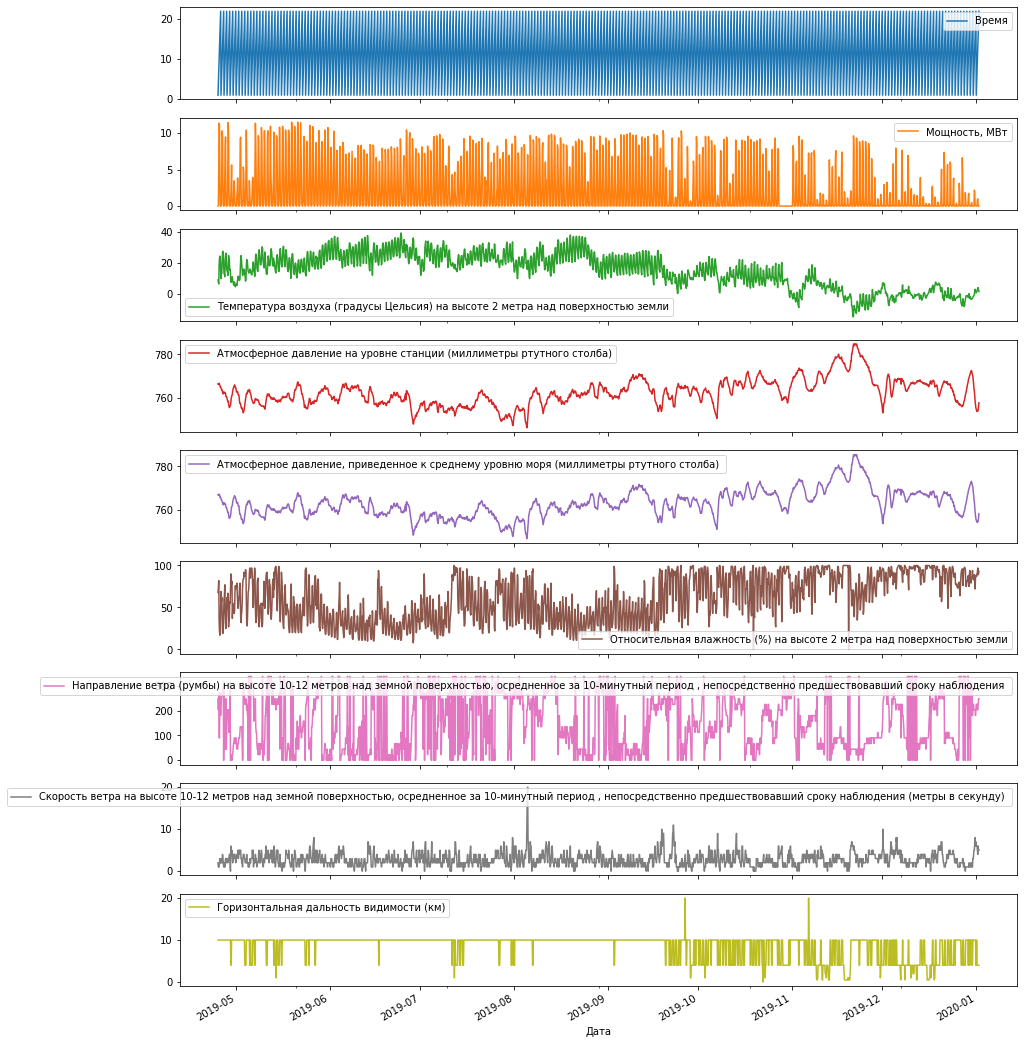

In [12]:
series.plot(subplots=True,figsize=(15,20))

###Создание датасета

In [0]:
split_datetime = 1500

Приведение колонки "Время" к целому

In [65]:
series.insert(0,'Месяц', series.index.month)
series.columns
series.head()

,Месяц,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,,
2019-04-25 01:00:00.000,4,01:00:00,0.000000,9.1,766.4,766.9,68.0,247.5,2,10.0
2019-04-25 04:00:00.000,4,04:00:00,0.147833,7.6,766.1,766.6,73.0,202.5,1,10.0
2019-04-25 06:59:59.995,4,07:00:00,5.024833,6.5,766.2,766.7,82.0,270.0,1,10.0
2019-04-25 09:59:59.995,4,10:00:00,11.363389,18.8,766.7,767.2,34.0,90.0,1,10.0
2019-04-25 12:59:59.995,4,13:00:00,10.962667,23.0,766.3,766.9,22.0,90.0,2,10.0


In [66]:
series['Время']=series.index.hour# series['Время'].map(lambda x: np.int(x.strftime('%H')))#.astype(np.string_)#.map(lambda x: x.strftime('%H'))
series.head()

,Месяц,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,,
2019-04-25 01:00:00.000,4,1,0.000000,9.1,766.4,766.9,68.0,247.5,2,10.0
2019-04-25 04:00:00.000,4,4,0.147833,7.6,766.1,766.6,73.0,202.5,1,10.0
2019-04-25 06:59:59.995,4,6,5.024833,6.5,766.2,766.7,82.0,270.0,1,10.0
2019-04-25 09:59:59.995,4,9,11.363389,18.8,766.7,767.2,34.0,90.0,1,10.0
2019-04-25 12:59:59.995,4,12,10.962667,23.0,766.3,766.9,22.0,90.0,2,10.0


нормализация данных

In [67]:
series.drop(columns=['Время','Месяц']).head()

,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Горизонтальная дальность видимости (км)
Дата,,,,,,,,
2019-04-25 01:00:00.000,0.000000,9.1,766.4,766.9,68.0,247.5,2,10.0
2019-04-25 04:00:00.000,0.147833,7.6,766.1,766.6,73.0,202.5,1,10.0
2019-04-25 06:59:59.995,5.024833,6.5,766.2,766.7,82.0,270.0,1,10.0
2019-04-25 09:59:59.995,11.363389,18.8,766.7,767.2,34.0,90.0,1,10.0
2019-04-25 12:59:59.995,10.962667,23.0,766.3,766.9,22.0,90.0,2,10.0


In [75]:
cols = (~series.columns.isin(['Месяц','Время']))
cols

array([False, False,  True,  True,  True,  True,  True,  True,  True,
        True])

In [0]:
cols = (~series.columns.isin(['Месяц','Время']))
data_mean= series.loc[:, cols][:split_datetime].mean(axis=0)
data_std = series.loc[:, cols][:split_datetime].std(axis=0)
series.loc[:, cols] = (series.loc[:, cols]-data_mean)/data_std

проба из https://www.tensorflow.org/tutorials/structured_data/time_series

In [0]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)
######################################
# past_history = window_size
# future_target = 1
# STEP = 1
# ds= series.values
# target = series['Мощность, МВт'].values
# x_train_single, y_train_single = multivariate_data(ds, target, 0,
#                                                    split_datetime, past_history,
#                                                    future_target, STEP,
#                                                    single_step=True)

###Оформление оконного датасета

In [0]:
window_size = int(24/4*30)
batch_size = 32
shuffle_buffer_size = 1000

x_train = series[:split_datetime]
# y_train = target[:split_datetime]
x_valid = series[split_datetime:]
# y_valid = target[split_datetime:]


def windowed_dataset(series, target, window_size, batch_size, shuffle_buffer):
  target_colnum=series.columns.get_loc(target)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.map(lambda window: (window[:-1], window[-1,target_colnum]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [0]:
tf.keras.backend.clear_session()

ds_train = windowed_dataset(x_train, 'Мощность, МВт', window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)
ds_val_x = windowed_dataset(x_valid, 'Мощность, МВт', window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)


In [0]:
# target='Мощность, МВт'
# target_colnum=series.columns.get_loc(target)
# dataset = tf.data.Dataset.from_tensor_slices(series)
# dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
# dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
# dataset = dataset.map(lambda window: (window[:-1], window[-1,target_colnum]))
# iterator = dataset.as_numpy_iterator()# tf.compat.v1.data.Iterator.from_structure(ds_train.output_types,ds_train.output_shapes)
# X, y = iterator.next()
# print(y)
# print(series[target][:window_size+1])

###Сборка и тренировка модели

In [91]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(75, input_shape=(None, x_train.shape[1]), return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
epoch_num=300
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.002)
model.compile(loss="mse", optimizer=optimizer, metrics=['mae'])
history = model.fit(ds_train, validation_data=(ds_val_x), epochs=epoch_num)#,callbacks=[lr_schedule])

Epoch 1/300

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

11/11 [==============================] - 3s 300ms/step - loss: 1.3438 - mae: 0.8969 - val_loss: 0.2739 - val_mae: 0.4115
Epoch 2/300
11/11 [==============================] - 2s 171ms/step - loss: 0.5760 - mae: 0.5722 - val_loss: 0.2813 - val_mae: 0.4301
Epoch 3/300
11/11 [==============================] - 2s 171ms/step - loss: 0.4524 - mae: 0.4922 - val_loss: 0.2677 - val_mae: 0.4157
Epoch 4/300
11/11 [==============================] - 2s 173ms/step - loss: 0.3660 - mae: 0.4364 - val_loss: 0

In [0]:
import matplotlib.pyplot as plt
 
# lrs = 1e-8 * (10 ** (np.arange(200) / 20))
# plt.semilogx(lrs, history.history["val_loss"][:])
# plt.axis([1e-8, 200, 0, 20])

###Анализ функции потерь

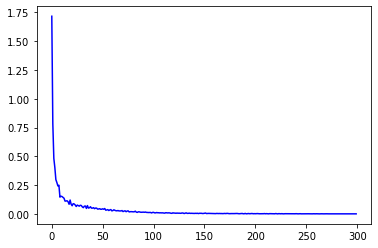

In [83]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

[0.04608295112848282, 0.042047277092933655, 0.0486166812479496, 0.03426271677017212, 0.03592357039451599, 0.03919147700071335, 0.03125622496008873, 0.036297328770160675, 0.03954722732305527, 0.028281016275286674, 0.031003089621663094, 0.03737141191959381, 0.03266070783138275, 0.029616443440318108, 0.02873404137790203, 0.031071145087480545, 0.027760617434978485, 0.028025083243846893, 0.02768155373632908, 0.030734241008758545, 0.0221821591258049, 0.026159202679991722, 0.028993766754865646, 0.02103910595178604, 0.026232099160552025, 0.028461046516895294, 0.018949996680021286, 0.02095617540180683, 0.02147931605577469, 0.020608805119991302, 0.020006636157631874, 0.020277900621294975, 0.02557242475450039, 0.01742110773921013, 0.015110602602362633, 0.019992223009467125, 0.0196928009390831, 0.016824550926685333, 0.016094187274575233, 0.01644721068441868, 0.017221756279468536, 0.01604275219142437, 0.017890267074108124, 0.015090519562363625, 0.014015227556228638, 0.013854331336915493, 0.01463529

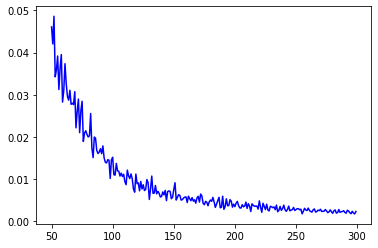

In [84]:
# Plot all but the first 10
loss = history.history['loss']
startpos= 50
epochs = range(50, len(loss))
plot_loss = loss[50:]
print(plot_loss)
plt.plot(epochs, plot_loss, 'b', label='Training Loss')
plt.show()

<Figure size 432x288 with 0 Axes>

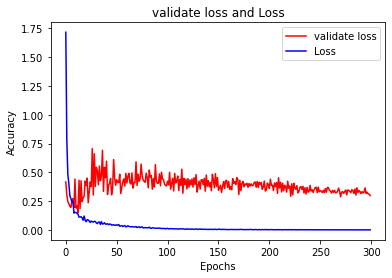

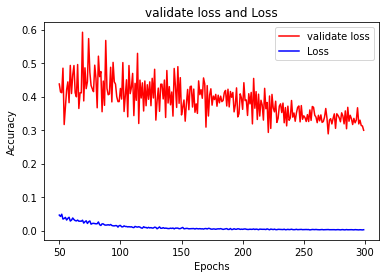

<Figure size 432x288 with 0 Axes>

In [85]:
val_loss=history.history['val_loss']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot validate loss and Loss
#------------------------------------------------
plt.plot(epochs, val_loss, 'r')
plt.plot(epochs, loss, 'b')
plt.title('validate loss and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

epochs_zoom = epochs[50:]
mae_zoom = val_loss[50:]
loss_zoom = loss[50:]

#------------------------------------------------
# Plot Zoomed validate loss and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('validate loss and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["validate loss", "Loss"])

plt.figure()

### График сравнения предсказанной мощности с реальной, взятой из таблице

In [0]:
forecast=[]
for t in range(len(series) - window_size):
  pred=np.expand_dims(series[t:t+window_size],0)
  forecast.append(model.predict(pred).flatten())

results = forecast[split_datetime-window_size:]
results = np.array(results)#[:, 0, 0]




In [0]:
def plot_series(time, series, format="-", start=0, end=None, legend=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.legend(legend)
    plt.grid(True)

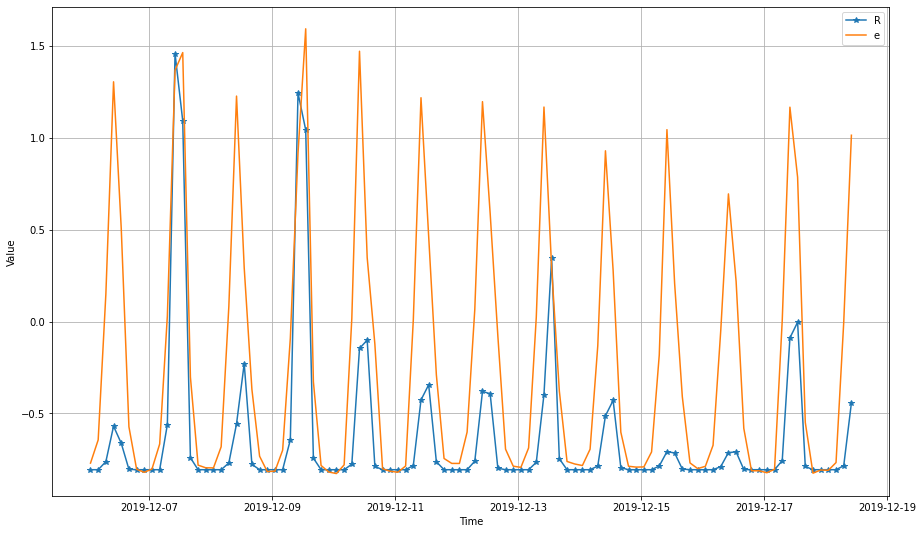

In [88]:
#import matplotlib.pyplot as plt

time_train = x_valid.index.to_numpy(dtype=np.datetime64)
plt.figure(figsize=(15, 9))
# plt.legend(['res', 'power'])
plot_series(time_train, x_valid['Мощность, МВт'], format='-*',start=300,end=400, legend='Power')
plot_series(time_train, results,start=300,end=400,  legend='Result')

In [89]:
Dosang = pd.read_excel("https://github.com/andrew-veriga/sunpower/raw/master/SES_5_Dosang_-_gotovo.xlsx",parse_dates=["Дата"], index_col="Дата")
Dosang.head()

,№ п/п,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Общая облачность,"Текущая погода, сообщаемая с метеорологической станции",Прошедшая погода между сроками наблюдения 1,Прошедшая погода между сроками наблюдения 2,"Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака","Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm",Высота основания самых низких облаков (м),"Высококучевые, высокослоистые и слоисто-дождевые облака","Перистые, перисто-кучевые и перисто-слоистые облака",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,,,,,,,,,,,
2019-04-26 01:00:00.000,1,01:00:00,0.000000,10.0,764.4,764.9,69.0,225.0,2,20–30%.,,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",Облаков нет.,"2500 или более, или облаков нет.","Высококучевых, высокослоистых или слоисто-дожд...","Перистые нитевидные, иногда когтевидные, не ра...",10.0
2019-04-26 04:00:00.000,2,04:00:00,0.000000,13.6,764.1,764.5,57.0,247.5,3,70 – 80%.,,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",70 – 80%.,"2500 или более, или облаков нет.",Высококучевые башенкообразные или хлопьевидные.,"Перистых, перисто-кучевых или перисто-слоистых...",10.0
2019-04-26 06:59:59.995,3,07:00:00,0.166333,13.3,763.6,764.2,62.0,270.0,2,"90 или более, но не 100%",,NaN,NaN,"Слоисто-кучевые, образовавшиеся не из кучевых.","10% или менее, но не 0",1000-1500,"Высококучевые просвечивающие, расположенные на...","Перистые нитевидные, иногда когтевидные, не ра...",10.0
2019-04-26 09:59:59.995,4,10:00:00,5.604889,21.3,763.6,764.0,41.0,270.0,2,50%.,,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...",50%.,"2500 или более, или облаков нет.","Высококучевые просвечивающие, полосами, либо о...","Перистых, перисто-кучевых или перисто-слоистых...",10.0
2019-04-26 12:59:59.995,5,13:00:00,11.393389,26.9,762.7,763.3,20.0,270.0,4,"10% или менее, но не 0",,NaN,NaN,"Слоисто-кучевых, слоистых, кучевых или кучево-...","10% или менее, но не 0","2500 или более, или облаков нет.","Высококучевые просвечивающие, полосами, либо о...","Перистых, перисто-кучевых или перисто-слоистых...",10.0


In [90]:
series = Dosang[
            [
            'Время',
            'Мощность, МВт',
            'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
            'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
            'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба) ',
            'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
            'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения ',
            'Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду) ',
            # 'Общая облачность',
            # 'Текущая погода, сообщаемая с метеорологической станции ',
            # 'Прошедшая погода между сроками наблюдения 1',
            # 'Прошедшая погода между сроками наблюдения 2',
            # 'Слоисто-кучевые, слоитсые, кучевые и кучево-дождевые облака',
            # 'Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдащихся облаков Cm',
            # 'Высота основания самых низких облаков (м)',
            # 'Высококучевые, высокослоистые и слоисто-дождевые облака',
            # 'Перистые, перисто-кучевые и перисто-слоистые облака',
            'Горизонтальная дальность видимости (км)'
             ]].fillna(0)#.asfreq(None)
            
            
series.head()

,Время,"Мощность, МВт",Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли,Атмосферное давление на уровне станции (миллиметры ртутного столба),"Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)",Относительная влажность (%) на высоте 2 метра над поверхностью земли,"Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения","Скорость ветра на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период , непосредственно предшествовавший сроку наблюдения (метры в секунду)",Горизонтальная дальность видимости (км)
Дата,,,,,,,,,
2019-04-26 01:00:00.000,01:00:00,0.000000,10.0,764.4,764.9,69.0,225.0,2,10.0
2019-04-26 04:00:00.000,04:00:00,0.000000,13.6,764.1,764.5,57.0,247.5,3,10.0
2019-04-26 06:59:59.995,07:00:00,0.166333,13.3,763.6,764.2,62.0,270.0,2,10.0
2019-04-26 09:59:59.995,10:00:00,5.604889,21.3,763.6,764.0,41.0,270.0,2,10.0
2019-04-26 12:59:59.995,13:00:00,11.393389,26.9,762.7,763.3,20.0,270.0,4,10.0
